# Evaluation of Tentacle's counts/coverage accuracy
This document explains the evaluation of the counts/coverage accuracy evaluation of Tentacle, as part of the Tentacle publication (Boulund, et al. 2015).

For more information on Tentacle, visit the project homepage at http://bioinformatics.math.chalmers.se/tentacle/

## Experimental design

### Three samples
The data used in this study consists of three randomly chosen samples from Qin et al. (2010) (doi:[10.1038/nature08821](http://dx.doi.org/10.1038/nature08821)):

|Sample|Reads|Reads stats|Contigs|Contig stats|
|---|---|---|---|---|
|MH0050|MH0050_081223.raw.1.fq|11680508 reads; 887718608 nt, 76 nt/read|MH0050.seq.fa|71587 contigs;109111010 nt, 1524.17 nt/contig|
|V1.CD-4|V1.CD-4_090107.raw.1.fq|10179531 reads; 773644356 nt, 76 nt/read|V1.CD-4.seq.fa|64855 contigs; 101050459 nt, 1558.098 nt/contig|
|V1.UC-6|V1.UC-6_090104.raw.1.fq|11017396 reads; 837322096 nt, 76 nt/read|V1.UC-6.seq.fa|88651 contigs; 125340688 nt, 1413.87 nt/contig|

### Spiked sample preparation
Random "reads" were drawn from a subset (10 %) of the reference contigs. These "reads" were used to spike the original samples. The 10 % subset of contigs was randomly chosen from all contigs at least 2500 nt in length for each sample. 

|Sample|Subset of contigs|# nt in contigs subset|# 76bp "reads" required for 1x coverage|
|---|---|---|---|
|MH0050|MH0050.subset.fasta|35579439|468150.513|
|V1.CD-4|V1.CD-4.subset.fasta|35604535|468480.724|
|V1.UC-6|V1.UC-6.subset.fasta|45095244|593358.474|

#### Spiking data generation
For each sample, a "spiking" data set of 76bp reads was randomly generated in triple replicates, at four levels of coverage (1x, 10x, 100x, 1000x). The spiking data sets were then merged with the original data set to create the spiked data sets for which Tentacle was used to compute coverage and counts. Thus the total number of unique files in the evaluation was $N*M*L+3=39$, with $N=3$ samples, $M=3$ replicates, at $L=4$ levels, plus the $3$ clean samples. 

### Computing counts/coverage using Tentacle
The counts/coverage for each of the files were computed using [pBLAT](http://icebert.github.io/pblat/) in Tentacle, using the default settings. 

## Results
The results were parsed, computed, and plotted using this IPython Notebook. The complete details are available below, with plots at the bottom. 

In [1]:
# Load required libraries
import matplotlib
matplotlib.use("Agg")
%matplotlib inline
from pylab import *
import numpy as np
from scipy.stats import sem
from fnmatch import fnmatch
from os import listdir
from itertools import izip, izip_longest
import seaborn as sns

In [2]:
# Define functions to preprocess the data
def groupby(iterable, n):
    """ Group the output of an iterable into groups of n.
    """
    args = [iter(iterable)] * n
    return izip_longest(*args)


def parse_tentacle_output(fn, allowed_contigs=set()):
    """ Parse output from Tentacle.
        
        Returns count and mean coverage for each annotated region in the results.
    """
    with open(fn) as f:
        for line in f:
            region, count, median, mean, stdev = line.strip().split()
            if allowed_contigs:
                contig = "_".join(region.split("_", 3)[:3])
                if contig in allowed_contigs:
                    yield (float(count), float(mean))


def create_coverage_generators(dirname, sample):
    """ Create a list of 12 generators (three per coverage level)
    """
    generator_list = []
    for fn in listdir(dirname):
        if fnmatch(fn, "*{}*".format(sample)):
            generator_list.append(parse_tentacle_output(dirname+fn, allowed_contigs=spiked_contigs[sample]))
    assert(len(generator_list)==12)
    return generator_list


def parse_spiked_contigs(fn):
    """ Create a list of spiked contigs.
    
        Parse the names of all contigs selected for spiking for each sample.
    """
    contigs = []
    with open(fn) as f:
        for line in f:
            if line.startswith(">"):
                contigs.append(line.strip()[1:])
    return contigs


def normalize_results_to_clean_run(num_spiked_contigs, clean_generator, sample_generators):
    """ Go through iterators in lock-step and normalize each contig by subtracting results from the clean run.
        Returns an ndarray with three dimensions. I see it as two two-dimensional arrays;
        one for counts and one for means. Each two-dimensional array has num_spiked_contig rows and 12 columns.
        Dimensions of the returned ndarray:
            First (2):  counts, means
            Second (12):  1000x_1, 1000x_2, 1000x_3, 100x_1, 100x_2, 100x_3, 10x_1, 10x_2, 10x_3, 1x_1, 1x_2, 1x_3
            Third (num_spiked_contigs):  [one row for each spiked contig in sample]
            
    """
    normalized_sample_results = np.ndarray(shape=(2, num_spiked_contigs, 12))
    for idx, counts_means in enumerate(izip(clean_generator, *sample_generators)):
        counts, means = zip(*counts_means)
        # Normalize by subtracting the "clean" mapping levels
        normalized_row_counts = np.subtract(counts[1:], counts[0]) 
        normalized_row_means = np.subtract(means[1:], means[0])
        normalized_sample_results[0, idx,:] = normalized_row_counts
        normalized_sample_results[1, idx, :] = normalized_row_means
    return normalized_sample_results

In [3]:
# Create sets with names of spiked contigs for each sample
spiked_contigs = {}
for fn in listdir("spike_contigs"):
    samplename = fn.split(".subset")[0]
    spiked_contigs[samplename] = set(parse_spiked_contigs("spike_contigs/"+fn))

In [4]:
# Create generators to iterate through the results for each sample in lock-step
clean_generators = {}
for fn in listdir("pblat_results_clean/results/"):
    sample = fn.split("_", 1)[0]
    clean_generators[sample] = parse_tentacle_output("pblat_results_clean/results/"+fn, allowed_contigs=spiked_contigs[sample])
sample1_generators = create_coverage_generators("pblat_results_spiked/results/", "MH0050")
sample2_generators = create_coverage_generators("pblat_results_spiked/results/", "V1.CD-4")
sample3_generators = create_coverage_generators("pblat_results_spiked/results/", "V1.UC-6")

In [5]:
# Read and normalize the results for each contig to the "clean" level for each contig
sample1_normalized = normalize_results_to_clean_run(7169, clean_generators["MH0050"], sample1_generators)
sample2_normalized = normalize_results_to_clean_run(6485, clean_generators["V1.CD-4"], sample2_generators)
sample3_normalized = normalize_results_to_clean_run(8865, clean_generators["V1.UC-6"], sample3_generators)

In [6]:
# Compute summary statistics of the increases between levels for each level
s1_counts = np.apply_along_axis(np.mean, 0, sample1_normalized[0, :, :])
s2_counts = np.apply_along_axis(np.mean, 0, sample2_normalized[0, :, :])
s3_counts = np.apply_along_axis(np.mean, 0, sample3_normalized[0, :, :])
s1_means = np.apply_along_axis(np.mean, 0, sample1_normalized[1, :, :])
s2_means = np.apply_along_axis(np.mean, 0, sample2_normalized[1, :, :])
s3_means = np.apply_along_axis(np.mean, 0, sample3_normalized[1, :, :])

# Normalize the increase between the samples to the mean of the 1x coverage runs
s1_counts_increases = np.divide(s1_counts, np.mean(s1_counts[9:12]))
s2_counts_increases = np.divide(s2_counts, np.mean(s2_counts[9:12]))
s3_counts_increases = np.divide(s3_counts, np.mean(s3_counts[9:12]))
s1_means_increases = np.divide(s1_means, np.mean(s1_means[9:12]))
s2_means_increases = np.divide(s2_means, np.mean(s2_means[9:12]))
s3_means_increases = np.divide(s3_means, np.mean(s3_means[9:12]))

# Reduce the means to four; one per coverage level to reduce clutter in plot
s1_counts_increase = [np.mean(run) for run in groupby(s1_counts_increases, 3)]
s2_counts_increase = [np.mean(run) for run in groupby(s2_counts_increases, 3)]
s3_counts_increase = [np.mean(run) for run in groupby(s3_counts_increases, 3)]
s1_means_increase = [np.mean(run) for run in groupby(s1_means_increases, 3)]
s2_means_increase = [np.mean(run) for run in groupby(s2_means_increases, 3)]
s3_means_increase = [np.mean(run) for run in groupby(s3_means_increases, 3)]

# Compute standard errors for each coverage level (i.e. triplet of runs)
s1_counts_sem = [sem(run) for run in groupby(s1_counts_increases, 3)]
s2_counts_sem = [sem(run) for run in groupby(s2_counts_increases, 3)]
s3_counts_sem = [sem(run) for run in groupby(s3_counts_increases, 3)]
s1_means_sem = [sem(run) for run in groupby(s1_means_increases, 3)]
s2_means_sem = [sem(run) for run in groupby(s2_means_increases, 3)]
s3_means_sem = [sem(run) for run in groupby(s3_means_increases, 3)]

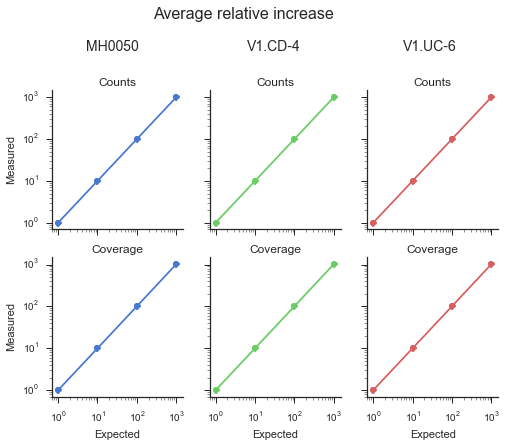

In [7]:
# Plot average increase in counts and coverage for each sample
sns.set_style("ticks")
colors = sns.color_palette("muted", 3)

xpoints = [1000, 100, 10, 1]
samples = zip(("MH0050", "V1.CD-4", "V1.UC-6"), 
              ((s1_counts_increase, s1_means_increase),
               (s2_counts_increase, s2_means_increase), 
               (s3_counts_increase, s3_means_increase)),
              ((s1_counts_sem, s1_means_sem),
               (s2_counts_sem, s2_means_sem),
               (s3_counts_sem, s3_means_sem)))

fig, axes = plt.subplots(nrows=2, ncols=3, sharey=True, sharex=True)
for idx, sample in enumerate(samples):
    sample_name, sample_data, sample_sem = sample
    axes[0, idx].loglog(xpoints, sample_data[0], "o-", color=colors[idx])
    axes[1, idx].loglog(xpoints, sample_data[1], "o-", color=colors[idx])
    #axes[0, idx].errorbar(xpoints, sample_data[0], yerr=sample_sem[0], color=colors[idx]) # Errorbars too small to be seen
    #axes[1, idx].errorbar(xpoints, sample_data[1], yerr=sample_sem[1], color=colors[idx]) # Errorbars too small to be seen
    axes[1, idx].set_xlabel("Expected")
    axes[0, idx].set_title("Counts")
    axes[1, idx].set_title("Coverage")
    axes[0, idx].set_xlim([.7, 1500])
    axes[1, idx].set_ylim([.7, 1500])

axes[0, 0].set_ylabel("Measured")
axes[1, 0].set_ylabel("Measured")
plt.figtext(0.30, 1.08, "Average relative increase", size=16)
plt.figtext(0.23, 1, "MH0050", fontsize=14, horizontalalignment="center")
plt.figtext(0.51, 1, "V1.CD-4", fontsize=14, horizontalalignment="center")
plt.figtext(0.78, 1, "V1.UC-6", fontsize=14, horizontalalignment="center")
sns.despine()
fig.savefig("increases.svg")
fig.savefig("increases.pdf")

In [8]:
# Print the standard error at each coverage level
print "Standard error at each coverage level"
standard_errors = [(s1_counts_sem, s1_means_sem),
                   (s2_counts_sem, s2_means_sem),
                   (s3_counts_sem, s3_means_sem)]
kinds = ["Counts", "Coverage"]
levels = ["1000x", "100x", "10x", "1x"]
for idx, stderrs in enumerate(np.apply_along_axis(sem, 0, standard_errors)):
    print kinds[idx]
    for jdx, stderr in enumerate(stderrs):
        print "{:<5} {:<4f}".format(levels[jdx], stderr)

Standard error at each coverage level
Counts
1000x 0.004536
100x  0.000552
10x   0.000060
1x    0.000032
Coverage
1000x 0.028408
100x  0.001265
10x   0.000201
1x    0.000105


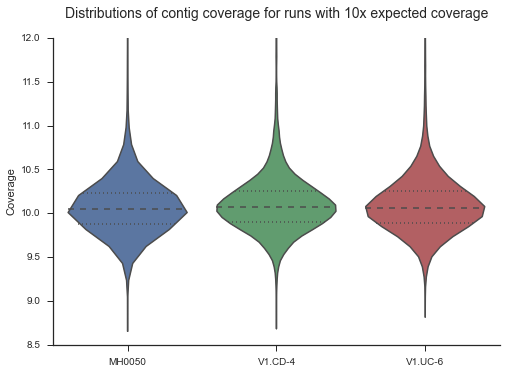

In [9]:
# Plot distributions of contig coverage for each sample
s1_mean_10x = np.apply_along_axis(np.mean, 1, sample1_normalized[1, :, 6:9])
s2_mean_10x = np.apply_along_axis(np.mean, 1, sample2_normalized[1, :, 6:9])
s3_mean_10x = np.apply_along_axis(np.mean, 1, sample3_normalized[1, :, 6:9])
sns.violinplot([s1_mean_10x, s2_mean_10x, s3_mean_10x], names=["MH0050", "V1.CD-4", "V1.UC-6"])
plt.ylim((8.5, 12.0))
plt.title("Distributions of contig coverage for runs with 10x expected coverage", size=14, y=1.05)
plt.ylabel("Coverage")
sns.despine()
savefig("violins.svg")
savefig("violins.pdf")

In [10]:
# Print the median of the mean coverage estimations for each sample and level
print "1x"
print np.mean((np.apply_along_axis(np.median, 1, sample1_normalized[1, :, 9:12])))
print np.mean((np.apply_along_axis(np.median, 1, sample2_normalized[1, :, 9:12])))
print np.mean((np.apply_along_axis(np.median, 1, sample3_normalized[1, :, 9:12])))
print "10x"
print np.mean((np.apply_along_axis(np.median, 1, sample1_normalized[1, :, 6:9])))
print np.mean((np.apply_along_axis(np.median, 1, sample2_normalized[1, :, 6:9])))
print np.mean((np.apply_along_axis(np.median, 1, sample3_normalized[1, :, 6:9])))
print "100x"
print np.mean((np.apply_along_axis(np.median, 1, sample1_normalized[1, :, 3:6])))
print np.mean((np.apply_along_axis(np.median, 1, sample2_normalized[1, :, 3:6])))
print np.mean((np.apply_along_axis(np.median, 1, sample3_normalized[1, :, 3:6])))
print "1000x"
print np.mean((np.apply_along_axis(np.median, 1, sample1_normalized[1, :, 0:3])))
print np.mean((np.apply_along_axis(np.median, 1, sample2_normalized[1, :, 0:3])))
print np.mean((np.apply_along_axis(np.median, 1, sample3_normalized[1, :, 0:3])))

1x
1.00809740608
1.00621005166
1.00648546938
10x
10.0980551931
10.0916585839
10.0922906391
100x
101.769430123
101.853991274
101.779641669
1000x
1029.46341867
1029.42308932
1029.82796602


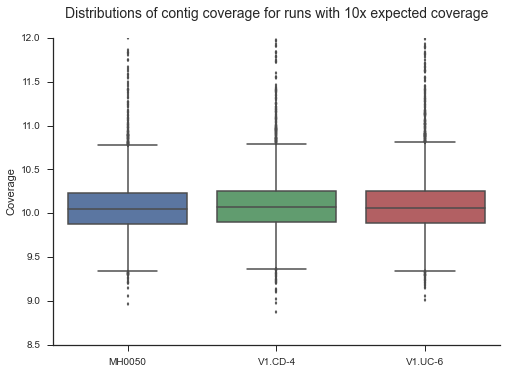

In [11]:
# Plot distributions of contig coverage for each sample
s1_mean_10x = np.apply_along_axis(np.mean, 1, sample1_normalized[1, :, 6:9])
s2_mean_10x = np.apply_along_axis(np.mean, 1, sample2_normalized[1, :, 6:9])
s3_mean_10x = np.apply_along_axis(np.mean, 1, sample3_normalized[1, :, 6:9])
sns.boxplot([s1_mean_10x, s2_mean_10x, s3_mean_10x], names=["MH0050", "V1.CD-4", "V1.UC-6"])
plt.ylim((8.5, 12.0))
plt.title("Distributions of contig coverage for runs with 10x expected coverage", size=14, y=1.05)
plt.ylabel("Coverage")
sns.despine()
savefig("boxplots.svg")

Number of outliers not shown in plot:
MH0050 : 51 outlier points above coverage 12 (7169 points total)
V1.CD-4: 22 outlier points above coverage 12 (6485 points total)
V1.UC-6: 28 outlier points above coverage 12 (8865 points total)


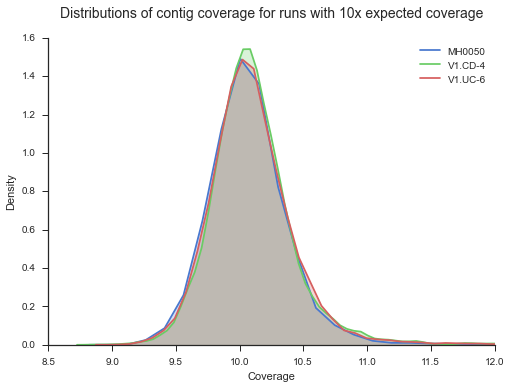

In [17]:
# Plot distribution s of contig coverage for each sample 
sns.kdeplot(s1_mean_10x, shade=True, color=colors[0], label="MH0050")
sns.kdeplot(s2_mean_10x, shade=True, color=colors[1], label="V1.CD-4")
sns.kdeplot(s3_mean_10x, shade=True, color=colors[2], label="V1.UC-6")
#plt.plot([np.median(s1_mean_10x), np.median(s1_mean_10x)], [0, 1.6], color=colors[0]) # Median line
#plt.plot([np.median(s2_mean_10x), np.median(s2_mean_10x)], [0, 1.6], color=colors[1]) # Median line
#plt.plot([np.median(s3_mean_10x), np.median(s3_mean_10x)], [0, 1.6], color=colors[2]) # Median line
plt.xlim(8.5,12)
plt.title("Distributions of contig coverage for runs with 10x expected coverage", size=14, y=1.05)
plt.xlabel("Coverage")
plt.ylabel("Density")
sns.despine()
savefig("kdeplot.svg")

outlier_limit = 12
outliers = [len(o[o > outlier_limit]) for o in (s1_mean_10x, s2_mean_10x, s3_mean_10x)]
print "Number of outliers not shown in plot:"
print "MH0050 : {} outlier points above coverage {} ({} points total)".format(outliers[0], outlier_limit, len(s1_mean_10x))
print "V1.CD-4: {} outlier points above coverage {} ({} points total)".format(outliers[1], outlier_limit, len(s2_mean_10x))
print "V1.UC-6: {} outlier points above coverage {} ({} points total)".format(outliers[2], outlier_limit, len(s3_mean_10x))